*Before going any further, this would not have been possible without the Kaggle community support.*

# Melanoma Classification : Image Processing and Dataset Preparation

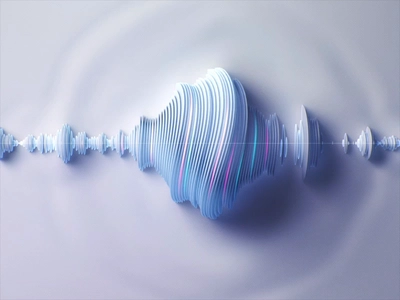 

## Motivation : 

So, I compiled my intitial results with `MobileNetv2`, `resNet50` and `EfficientNetB4`. Results were satisfying on the raw dataset extracted from the tfrecord files. The goal of this notebook is to `prepare a custom dataset by implementing several image processing operations` so that we can re-execute the aforementioned neural network architectures and compare the results in the two cases.

## Previous Works In Melanoma Competition : 

In case you haven't had the chance to explore my previous work, please access the notebooks using the following links. 

* Melanoma- A story in 3 parts- part One :
    **https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-one**

* Melanoma- A story in 3 parts-part Two : 
    **https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-two**

* Melanoma- A story in 3 parts-The Final Chapter [ *Under Construction* ]

* Melanoma-MobileNetV2
    **https://www.kaggle.com/fireheart7/melanoma-mobilenetv2**

* Melanoma-ResNet50 
    **https://www.kaggle.com/fireheart7/melanoma-resnet50**

**The additional dataset used in this notebook can be obtained from :**

**https://www.kaggle.com/fireheart7/melanoma-image-insights**

********************
Please consider upvoting if you find this worth your time!~~

All the very best for Melanoma classification competition!

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

/kaggle/input
/kaggle/input/siim-isic-melanoma-classification
/kaggle/input/siim-isic-melanoma-classification/tfrecords
/kaggle/input/siim-isic-melanoma-classification/train
/kaggle/input/siim-isic-melanoma-classification/test
/kaggle/input/siim-isic-melanoma-classification/jpeg
/kaggle/input/siim-isic-melanoma-classification/jpeg/train
/kaggle/input/siim-isic-melanoma-classification/jpeg/test
/kaggle/input/melanoma-image-insights


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [3]:
print("The version of Tensorflow being used = ", tf.__version__)

The version of Tensorflow being used =  2.2.0


# Loading Mandatory Files

In [4]:
train = pd.DataFrame(pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/train.csv"))
test = pd.DataFrame(pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/test.csv"))

print("Shape of Training data = ", train.shape)
print("Shape of Testing data = ", test.shape)

Shape of Training data =  (33126, 8)
Shape of Testing data =  (10982, 5)


In [5]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [7]:
train_image_stats_01 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_01"))
train_image_stats_02 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_02"))
train_image_stats_03 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_03"))
train_image_stats_04 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_04"))
train_image_stats_05 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_05"))
train_image_stats_06 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_06"))

print(train_image_stats_01.shape)
print(train_image_stats_02.shape)
print(train_image_stats_03.shape)
print(train_image_stats_04.shape)
print(train_image_stats_05.shape)
print(train_image_stats_06.shape)

(5000, 11)
(5000, 11)
(5000, 11)
(5000, 11)
(5000, 11)
(8126, 11)


In [8]:
train_image_statistics = pd.concat([train_image_stats_01, train_image_stats_02, train_image_stats_03,
                                   train_image_stats_04, train_image_stats_05, train_image_stats_06],
                                  ignore_index = True)
train_image_statistics.shape

(33126, 11)

In [9]:
train_image_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_name                33126 non-null  object 
 1   path                      33126 non-null  object 
 2   rows                      33126 non-null  int64  
 3   columns                   33126 non-null  int64  
 4   channels                  33126 non-null  int64  
 5   image_mean                33126 non-null  float64
 6   image_standard_deviation  33126 non-null  float64
 7   image_skewness            33126 non-null  float64
 8   mean_red_value            33126 non-null  float64
 9   mean_green_value          33126 non-null  float64
 10  mean_blue_value           33126 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 2.8+ MB


In [10]:
test_image_stats_01 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_test_01"))
test_image_stats_02 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_test_02"))

print(test_image_stats_01.shape)
print(test_image_stats_02.shape)

(5000, 11)
(5982, 11)


In [11]:
test_image_statistics = pd.concat([test_image_stats_01, test_image_stats_02], ignore_index = True)

test_image_statistics.shape

(10982, 11)

In [12]:
test_image_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_name                10982 non-null  object 
 1   path                      10982 non-null  object 
 2   rows                      10982 non-null  int64  
 3   columns                   10982 non-null  int64  
 4   channels                  10982 non-null  int64  
 5   image_mean                10982 non-null  float64
 6   image_standard_deviation  10982 non-null  float64
 7   image_skewness            10982 non-null  float64
 8   mean_red_value            10982 non-null  float64
 9   mean_green_value          10982 non-null  float64
 10  mean_blue_value           10982 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 943.9+ KB


In [13]:
train_image_statistics.head()

,image_name,path,rows,columns,channels,image_mean,image_standard_deviation,image_skewness,mean_red_value,mean_green_value,mean_blue_value
0,ISIC_2637011.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,169.862452,41.270046,-0.129492,212.933646,138.914514,157.739197
1,ISIC_0015719.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,171.084778,41.994142,-0.205430,217.279705,165.095320,130.879309
2,ISIC_0052212.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,1053,1872,3,158.691048,37.364873,-0.551454,199.940391,130.224750,145.908002
3,ISIC_0068279.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,1053,1872,3,80.342856,44.885518,0.453018,119.689502,62.614801,58.724265
4,ISIC_0074268.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,183.955453,37.497829,-0.157002,226.269270,173.175601,152.421488


In [14]:
test_image_statistics.head()

,image_name,path,rows,columns,channels,image_mean,image_standard_deviation,image_skewness,mean_red_value,mean_green_value,mean_blue_value
0,ISIC_0052060.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,189.424321,38.620205,-1.157524,218.487621,174.538942,175.246401
1,ISIC_0052349.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,206.967936,31.067482,-1.709788,232.954911,194.728591,193.220306
2,ISIC_0058510.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,218.997725,24.996260,-0.820638,245.152620,205.469878,206.370678
3,ISIC_0073313.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,216.520168,24.706621,-0.767840,239.212384,195.463032,214.885089
4,ISIC_0073502.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,1080,1920,3,146.340647,68.179568,-0.818278,171.169355,143.861384,123.991202


# Constructing Over What We Already Know  : 

Now, we will leverage the insights gained in part two of the Melanoma - three part story, I mentioned earlier. 

**Notebook link** : **https://www.kaggle.com/fireheart7/melanoma-a-story-in-3-parts-part-two** 

We generate 4 random samples from the training data set. These 4 samples are taken from the aforementioned array of names.

In [15]:
image_names = train_image_statistics["image_name"].values
random_images = [np.random.choice(image_names) for i in range(4)] # Generates a random sample from a given 1-D array
random_images 

['ISIC_7723074.jpg',
 'ISIC_8657064.jpg',
 'ISIC_2505880.jpg',
 'ISIC_3567352.jpg']

In [16]:
train_dir = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

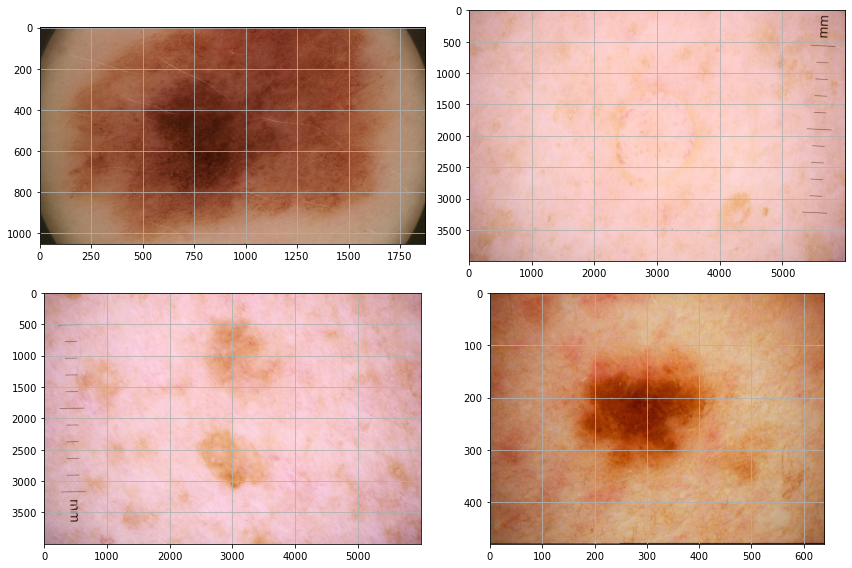

In [17]:
plt.figure(figsize = (12, 8))
for i in range(4) : 
    plt.subplot(2, 2, i + 1) 
    image = cv2.imread(os.path.join(train_dir, random_images[i]))
    # cv2 reads images in BGR format. Hence we convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap = "gray")
    plt.grid(True)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

## Insight #1 

From the color distribution charts in *Melanoma-A story in 3 parts-part Two* we effectively concluded that :

* In both `malignant` & `benign` cases the component of red spikes the most, whereas Blue and Green are close to each other. All the channels also appears to be a bit negatively skewed.

* Hence, the channel distribution won't be a powerful feature to differentiate between the malignant and benign cases.

Confirming our claim here : 

In [18]:
median_red_values_training = train_image_statistics["mean_red_value"].median()
median_red_values_testing = test_image_statistics["mean_red_value"].median()

median_green_values_training = train_image_statistics["mean_green_value"].median()
median_green_values_testing = test_image_statistics["mean_green_value"].median()


median_blue_values_training = train_image_statistics["mean_blue_value"].median()
median_blue_values_testing = test_image_statistics["mean_blue_value"].median()

print("The median of the distribution of mean RED values in training = ", median_red_values_training)
print("The median of the distribution of mean RED values in testing = ", median_red_values_testing)

print("\n")

print("The median of the distribution of mean GREEN values in training = ", median_green_values_training)
print("The median of the distribution of mean GREEN values in testing = ", median_green_values_testing)

print("\n")

print("The median of the distribution of mean BLUE values in training = ", median_blue_values_training)
print("The median of the distribution of mean BLUE values in testing = ", median_blue_values_testing)

The median of the distribution of mean RED values in training =  211.20021536643733
The median of the distribution of mean RED values in testing =  199.18065929545327


The median of the distribution of mean GREEN values in training =  164.95674637500002
The median of the distribution of mean GREEN values in testing =  152.65483340241735


The median of the distribution of mean BLUE values in training =  154.52386054166666
The median of the distribution of mean BLUE values in testing =  139.03091902015552


We see the median values are close enough, hence classifying based on a single channel alone would be risky.

In [19]:
train_image_statistics.head()

,image_name,path,rows,columns,channels,image_mean,image_standard_deviation,image_skewness,mean_red_value,mean_green_value,mean_blue_value
0,ISIC_2637011.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,169.862452,41.270046,-0.129492,212.933646,138.914514,157.739197
1,ISIC_0015719.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,171.084778,41.994142,-0.205430,217.279705,165.095320,130.879309
2,ISIC_0052212.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,1053,1872,3,158.691048,37.364873,-0.551454,199.940391,130.224750,145.908002
3,ISIC_0068279.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,1053,1872,3,80.342856,44.885518,0.453018,119.689502,62.614801,58.724265
4,ISIC_0074268.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,183.955453,37.497829,-0.157002,226.269270,173.175601,152.421488


## Resize All The Images : 

The images will be resized to 256 X 256.

In [20]:
def resize(image, image_shape) : 
    image = cv2.resize(image, [image_shape[0], image_shape[1]], cv2.INTER_NEAREST)
    return image

## Perform Denoising : 

Many image smoothing techniques like Gaussian Blurring, Median Blurring etc were good to some extent in removing small quantities of noise. In those techniques, we took a small neighbourhood around a pixel and performed some operations like gaussian weighted average, median of the values etc to replace the central element. In short, noise removal at a pixel was local to its neighbourhood.

There is a property of noise. **Noise is generally considered to be a random variable with zero mean**.

Suppose we hold a static camera to a certain location for a couple of seconds. This will give us plenty of frames, or a lot of images of the same scene. Then averaging all the frames, we compare the final result and first frame. Reduction in noise would be easily observed.

So idea is simple, we need a set of similar images to average out the noise. Considering a small window (say 5x5 window) in the image, chance is large that the same patch may be somewhere else in the image. Sometimes in a small neighbourhood around it. Hence, using these similar patches together averaging them can lead to an efficient denoised image.

This method is **Non-Local Means Denoising**. It takes more time compared to blurring techniques, but the result are very satisfying.

Illustration : 

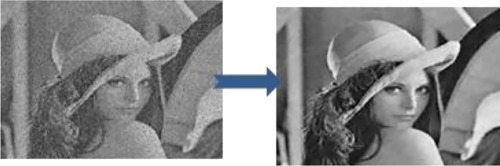 

## OpenCV implementation of the aforementioned approach :

cv2.fastNlMeansDenoisingColored() - Works on Colored images cv2.fastNlMeansDenoising() - Works on graysacle images

Common arguments are:

* h : parameter deciding filter strength. Higher h value removes noise better, but removes details of image also. (10 is ok)
* hForColorComponents : same as h, but for color images only. (normally same as h)
* templateWindowSize : should be odd. (recommended 7)
* searchWindowSize : should be odd. (recommended 21)

In [21]:
def non_local_means_denoising(image) : 
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

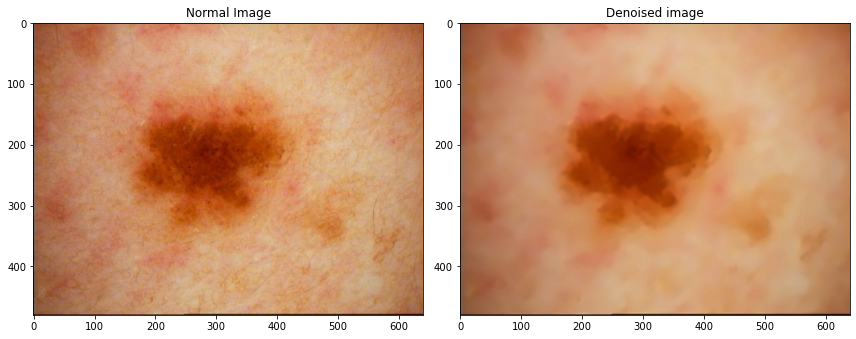

In [22]:
sample_image = cv2.imread(os.path.join(train_dir, random_images[3]))
# cv2 reads images in BGR format. Hence we convert it to RGB
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
denoised_image = non_local_means_denoising(sample_image)


plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image")

plt.subplot(1,2,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised image")    
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout() 

# Local Histogram Equalization : 

First of all, why can't we apply histogram equalization directly to an RGB image? Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is incorrect. 

*Equalization involves intensity values of the image, not the color components*.

So for a simple RGB color image, histogram equalization cannot be applied directly on the channels.It needs to be applied in such a way that the `intensity values are equalized without disturbing the color balance of the image`.

So, the first step is to convert the color space of the image from RGB into one of the color spaces that separates intensity values from color components. Some of the possible options are HSV/HLS, YUV, YCbCr, etc. 

`YCbCr is preferred as it is designed for digital images. Perform histogram equalization on the intensity plane Y. Now convert the resultant YCbCr image back to RGB`.

(Excerpt taken from :

https://prateekvjoshi.com/2013/11/22/histogram-equalization-of-rgb-images/ )

An illustration of histogram equalization : Observe the intensity difference

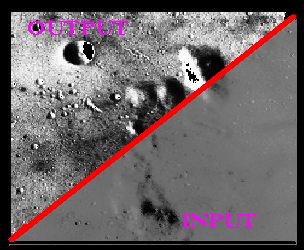 

Here we perform local histogram equalization, where we equalize intensities inside a rolling window of certain dimension instead of the whole image at once.

In [23]:
def histogram_equalization(image) : 
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    y_channel = image_ycrcb[:, :, 0] 
    cr_channel = image_ycrcb[:, :, 1]
    cb_channel = image_ycrcb[:, :, 2]
    
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    equalized = clahe.apply(y_channel)
    equalized_image = cv2.merge([equalized, cr_channel, cb_channel])
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_YCR_CB2RGB)
    return equalized_image

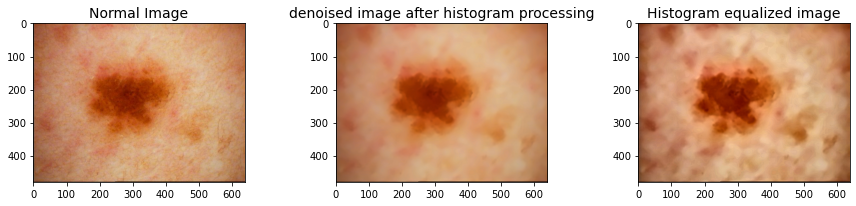

In [24]:
equalized_image = histogram_equalization(denoised_image)

plt.figure(figsize = (12, 8))
plt.subplot(1,3,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image", fontsize = 14)

plt.subplot(1,3,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("denoised image after histogram processing", fontsize = 14)

plt.subplot(1,3,3)  
plt.imshow(equalized_image, cmap = "gray")
plt.grid(False)
plt.title("Histogram equalized image", fontsize = 14)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

# Image Segmentation :

Is the technique of dividing or partitioning an image into parts, called segments. It is mostly useful for applications like image compression or object recognition, because for these types of applications, it is inefficient to process the whole image.

We will use **K-means clustering algorithm** to segment the images.

K-Means Segmentation Approach Using OpenCV

* samples : It should be of np.float32 data type, and each feature should be put in a single column. Here we have 3 channels, so every channel features have to be in one column. So, total columns we have are 3, while we don't care about the number of rows, hence -1. So, shape : (-1, 3).

* nclusters(K) : Number of clusters required at end.

* criteria : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are ( type, max_iter, epsilon ):
**************************

Type of termination criteria. It has 3 flags as below:

* cv.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
* cv.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
* cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.

**max_iter - An integer specifying maximum number of iterations. epsilon - Required accuracy**

* `attempts` : Flag to specify the number of times the algorithm is executed using different initial labellings. The algorithm returns the labels that yield the best compactness. This compactness is returned as output.

* `flags` : This flag is used to specify how initial centers are taken. Normally two flags are used for this : cv.KMEANS_PP_CENTERS and cv.KMEANS_RANDOM_CENTERS.

*****************************

Output parameters :

* `compactness` : It is the sum of squared distance from each point to their corresponding centers.
* `labels` : This is the label array (same as 'code' in previous article) where each element marked '0','1'.....
* `centers` : This is array of centers of clusters.

In [25]:
def k_means_segmentation(image, k, attempts) : 
    vectorized = np.float32(image.reshape((-1, 3)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    res, label, center = cv2.kmeans(vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape((image.shape))
    return segmented_image

Text(0.5, 1.0, 'Segmented Image with k = 5')

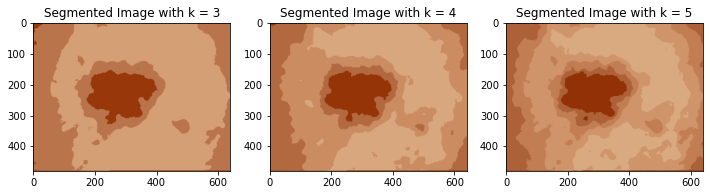

In [26]:
plt.figure(figsize = (12, 8))
segmented_image = k_means_segmentation(denoised_image, 3, 10) # k = 3, attempt = 10
plt.subplot(1,3,1)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 3")

segmented_image = k_means_segmentation(denoised_image, 4, 10) # k = 4, attempt = 10
plt.subplot(1,3,2)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 4")

segmented_image = k_means_segmentation(denoised_image, 5, 10) # k = 5, attempt = 10
plt.subplot(1,3,3)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 5")

We will fixate to k = 4 in future. Neither too less or nor too many clusters.

# Hair Removal In Dermoscopic Image : 


The research paper can be obtained from : 

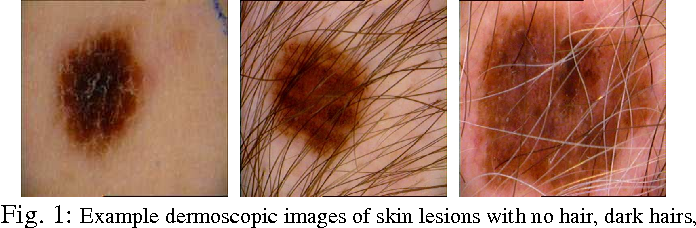

**https://www.intechopen.com/books/computer-methods-and-programs-in-biomedical-signal-and-image-processing/an-efficient-block-based-algorithm-for-hair-removal-in-dermoscopic-images** 

**************************

Hair removal is an important step in dermoscopy images to classify the skin lesion correctly into benign, suspicious, or malignant.

## Step(I) : Morphological Bottom-Hat Filtering : 

To detect hair pixels, a `morphological “bottom-hat”` operation is implemented on `Y-channel image`, returning the image minus the morphological closing of the image (dilation followed by erosion) to highlight dark hair on a light background. 

Hence, bottom-hat filtering produces highlighted areas, which more truly follow the shape of the hair. 

**The main motivation behind utilizing a bottom-hat filter is still the ability to better preserve the true shape of the hair**.

In [27]:
def bottom_hat_morphology(image, kernel) :
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    y_channel = image - closing
    return y_channel

## Step(II) : Otsu's Binarization

In global thresholding, we used an arbitrary chosen value as a threshold. In contrast, Otsu's method avoids having to choose a value and `determines it automatically`. 

Consider an image with only two distinct image values (bimodal image), where the histogram would only consist of two peaks. A good threshold would be in the middle of those two values. Similarly, `Otsu's method determines an optimal global threshold value from the image histogram`.

In [28]:
def image_binarization(image) : 
    otsu_threshold, otsu_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_image   

## Step(III) : Inpainting Operation : 



In [29]:
def hair_removal(image) : 
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    y_channel = image_ycrcb[:, :, 0]
    kernel = np.ones((5,5), dtype = np.uint8)
    y_channel = bottom_hat_morphology(y_channel, kernel)
    otsu_image = image_binarization(y_channel)
    cr_channel = image_ycrcb[:, :, 1]
    cb_channel = image_ycrcb[:, :, 2]

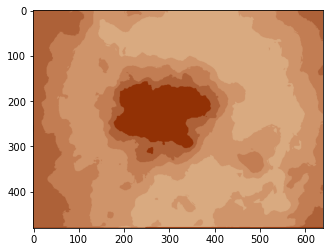

In [30]:
plt.imshow(segmented_image)

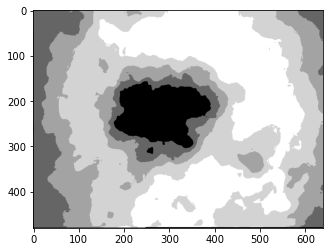

In [31]:
image_ycrcb = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2YCR_CB)
y_channel = image_ycrcb[:, :, 0]
plt.imshow(y_channel, cmap = "gray")

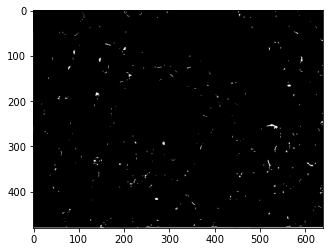

In [32]:
kernel = np.ones((5,5), dtype = np.uint8)
y_channel = bottom_hat_morphology(y_channel, kernel)
plt.imshow(y_channel, cmap = "gray")

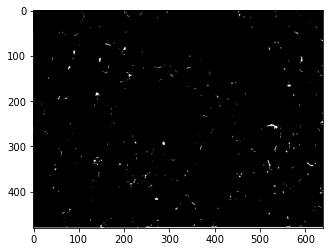

In [33]:
otsu_image = image_binarization(y_channel)
plt.imshow(otsu_image, cmap = "gray")